<a href="https://colab.research.google.com/github/pradeepprasad/Machine_Learning_Workspace/blob/master/Transfer_Learning_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf


In [2]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers


     |████████████████████████████████| 92kB 3.2MB/s 


Get the base model which will be used later to adjust for our needs.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}


In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


65536/61306 [================================] - 0s 0us/step


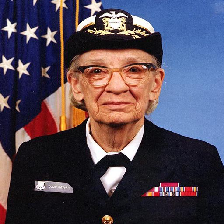

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper


In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape


(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape


(1, 1001)

Just checking what happens when eclipses are removed from parameter above.

In [9]:
result = classifier.predict(grace_hopper[np.newaxis])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class


653

Get the labels of imagenet.

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


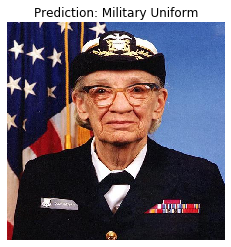

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())


Lets get the dataset for re-training for other use case.

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


228818944/228813984 [==============================] - 1s 0us/step


In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)


Found 3670 images belonging to 5 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape


(32, 1001)

In [21]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names


array(['cardoon', 'purse', 'daisy', 'teddy', 'velvet', 'shower cap',
       'pot', 'bakery', 'coral fungus', 'picket fence', 'boathouse',
       'picket fence', 'daisy', 'daisy', 'daisy', 'daisy', 'corn',
       'daisy', 'lakeside', 'hummingbird', 'volcano', 'rapeseed', 'titi',
       'cardoon', 'sea urchin', 'sea urchin', 'daisy', 'pot',
       'American egret', 'corn', 'chainlink fence', 'quill'], dtype='<U30')

Output will show you that base model provides incorrect prediction on new data set. Justification is base model is used trained on different use case. For flowers we will need retrain with flower dataset.

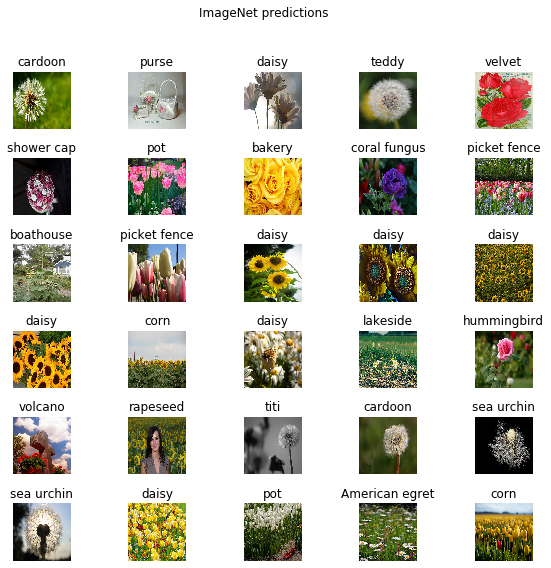

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


Above predicted labels are wrong except some which were there in base model training.

**Lets start Retraining base model by fetching headless version. Top layer would be non existing from model layers**

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


Now get feature extractor.

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [25]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(32, 1280)


All layers are now being frozen to avoid modification of already trained weights and only new layers will be trained.

In [0]:
feature_extractor_layer.trainable = False


Lets add classifier for our model by specifying number of classes require for our use case.

In [27]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)


In [29]:
predictions.shape


TensorShape([Dimension(32), Dimension(5)])

OK, lets compile and train model for our new data set.

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])


In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


To test we are working on 2 epochs only later we will go for full fledge training/

In [32]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


Epoch 1/2
115/115 [==============================] - 160s 1s/step - loss: 0.6639 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 161s 1s/step - loss: 0.3334 - acc: 0.9062


Lets plot the training metrics which is loss and accuracy.

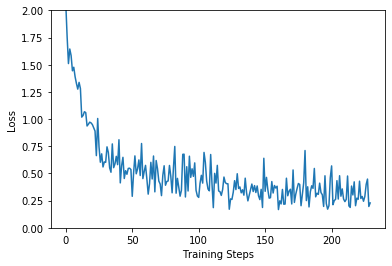

In [33]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


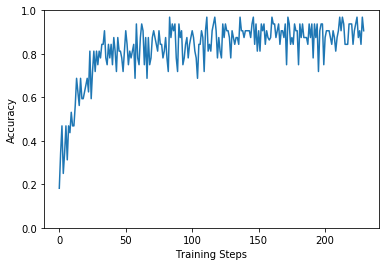

In [34]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


In [35]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


In [0]:
label_id = np.argmax(label_batch, axis=-1)


Lets plot the prediction label with indicator as green label for true and red for incorrect.

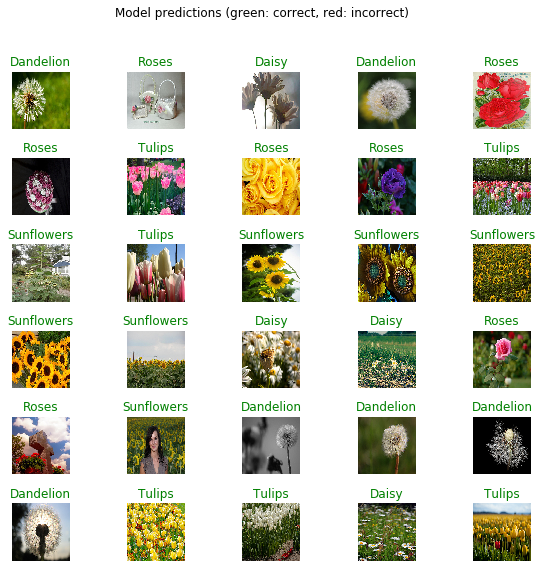

In [38]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


Lets save this model

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [41]:
import time
t = time.time()

export_path = "/content/drive/My Drive/temp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path


FailedPreconditionError: ignored

In [42]:
reloaded = tf.keras.modmodelels.load_model(export_path)


OSError: ignored

In [0]:
model.save('/content/drive/My Drive/temp/saved_models/' + 'transfer_learning_0.1', save_format= 'h5')

In [49]:
reloaded = tf.keras.models.load_model('/content/drive/My Drive/temp/saved_models/transfer_learning_0.1')


ValueError: ignored